
image 1/1 /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview/frame_000003.png: 384x640 1 person, 1 bottle, 3 beds, 155.9ms
Speed: 6.3ms preprocess, 155.9ms inference, 78.6ms postprocess per image at shape (1, 3, 384, 640)


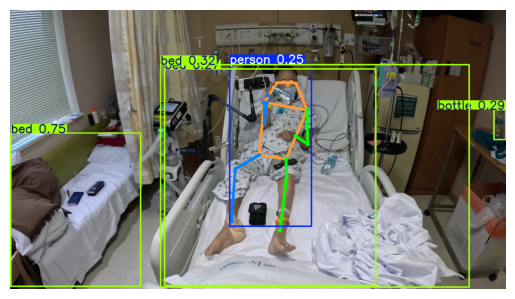

In [1]:
from ultralytics import YOLO  # YOLO 불러오기
import cv2  # OpenCV 불러오기
import matplotlib.pyplot as plt  # Jupyter에서 시각화

# 1) YOLOv11 모델 로드 (nano 버전: 가볍고 빠름)
model = YOLO("yolo11n.pt")  # yolo11n.pt 가중치를 불러옵니다.

# 2) 이미지 파일 경로 지정
img_path = "../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview/frame_000003.png"

# 3) 추론 실행
results = model(img_path)  # 해당 이미지에 대해 객체 감지를 수행합니다.

# 4) 결과 시각화 (720p로 리사이즈해서 출력)
for r in results:
    img = r.plot()  # bounding box와 라벨이 그려진 이미지
    img_resized = cv2.resize(img, (1280, 720))  # 출력 이미지를 720p로 리사이즈
    
    plt.imshow(img_resized[..., ::-1])  # BGR → RGB 변환 후 출력
    plt.axis("off")  # 축 제거
    plt.show()



image 1/1 /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview/frame_000015.png: 384x640 1 person, 1 bed, 2 cell phones, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


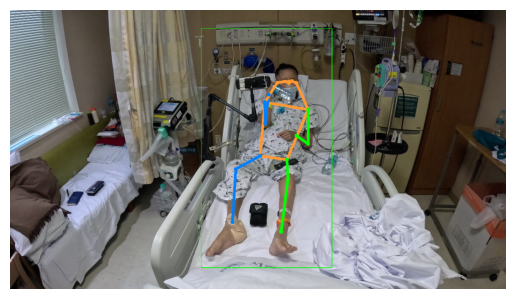

In [3]:
from ultralytics import YOLO  # YOLO 불러오기
import cv2  # OpenCV 불러오기
import matplotlib.pyplot as plt  # 시각화용
import numpy as np  # 수치 계산용

# 1) YOLOv11 모델 로드
model = YOLO("yolo11n.pt")  # nano 버전 가중치 불러오기

# 2) 이미지 파일 경로
img_path = "../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview/frame_000015.png"

# 3) 추론 실행
results = model(img_path)

# 4) margin 비율 설정
MARGIN_RATIO = 0.2  # BBox 크기의 20% 확장

# 5) 원본 이미지 로드
orig_img = cv2.imread(img_path)
h, w = orig_img.shape[:2]

# 6) 결과 처리
for r in results:
    boxes = r.boxes  # 감지된 객체들
    for box in boxes:
        cls_id = int(box.cls[0])  # 클래스 ID
        if model.names[cls_id] != "person":  # person이 아닌 경우 skip
            continue
        
        # 좌표 가져오기
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        
        # margin 계산
        bw, bh = x2 - x1, y2 - y1
        x1 = max(0, int(x1 - bw * MARGIN_RATIO))
        y1 = max(0, int(y1 - bh * MARGIN_RATIO))
        x2 = min(w, int(x2 + bw * MARGIN_RATIO))
        y2 = min(h, int(y2 + bh * MARGIN_RATIO))
        
        # 확장된 BBox 그리기
        cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

# 7) 최종 결과를 720p로 리사이즈 후 시각화
img_resized = cv2.resize(orig_img, (1280, 720))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [30]:
import cv2
import os
import warnings
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils import LOGGER

# 로그 최소화
LOGGER.setLevel("ERROR")
warnings.filterwarnings("ignore")

# 1) 모델 로드
model = YOLO("yolo11n-pose.pt")

# 2) 입력 & 출력 경로
input_mp4 = "/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/M02_VISIT12_하지1.MP4"
output_dir = "../data/test_patient_image/yolo"
os.makedirs(output_dir, exist_ok=True)
basename = os.path.splitext(os.path.basename(input_mp4))[0]
output_mp4 = os.path.join(output_dir, f"{basename}_yolo_pose_60s.mp4")

# 3) 비디오 정보
cap = cv2.VideoCapture(input_mp4)
fps = cap.get(cv2.CAP_PROP_FPS)
orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 앞 60초만 처리
duration_output = 60
frame_limit = int(min(total_frames, fps * duration_output))

resize_w, resize_h = 1280, 720
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_mp4, fourcc, fps, (resize_w, resize_h))

# 4) YOLO-Pose 실행 루프
for _ in tqdm(range(frame_limit), desc="YOLO-Pose video (60s)"):
    ret, frame = cap.read()
    if not ret:
        break

    # YOLO Pose 실행 (skeleton 포함)
    results = model(frame, verbose=False)

    # YOLO의 draw 기능으로 skeleton 그리기
    annotated_frame = results[0].plot()

    # 리사이즈 후 저장
    frame_resized = cv2.resize(annotated_frame, (resize_w, resize_h))
    out.write(frame_resized)

cap.release()
out.release()
print(f"[INFO] YOLO-Pose 기반 60초 영상 저장 완료: {output_mp4}")


YOLO-Pose video (60s): 100% 1798/1798 [01:30<00:00, 19.87it/s]

[INFO] YOLO-Pose 기반 60초 영상 저장 완료: ../data/test_patient_image/yolo/M02_VISIT12_하지1_yolo_pose_60s.mp4


In [17]:
import cv2
import os
import warnings
from ultralytics import YOLO
from ultralytics.utils import LOGGER
from tqdm import tqdm
import numpy as np

# 1) 로그 최소화
LOGGER.setLevel("ERROR")
warnings.filterwarnings("ignore")

# 2) YOLO 모델 로드
model = YOLO("yolo11n.pt")

# 3) 입력 & 출력 경로
input_mp4 = "/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/M03_VISIT12_하지.MP4"
output_dir = "../data/test_patient_image/yolo"
os.makedirs(output_dir, exist_ok=True)

basename = os.path.splitext(os.path.basename(input_mp4))[0]
output_mp4 = os.path.join(output_dir, f"{basename}_yolo_fixedbox.mp4")

# 4) 비디오 읽기
cap = cv2.VideoCapture(input_mp4)
fps = cap.get(cv2.CAP_PROP_FPS)
orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 5) 앞 30초 동안만 YOLO 실행
duration_sec = 30
frame_limit = int(min(total_frames, fps * duration_sec))

bbox_list = []  # BBox 좌표 저장
MARGIN_RATIO = 0.2
cx_img, cy_img = orig_w / 2, orig_h / 2

for _ in tqdm(range(frame_limit), desc="Calibrating with first 30s"):
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False)
    candidate_boxes = []

    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0])
            if model.names[cls_id] != "person":
                continue

            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            score = float(box.conf[0].cpu().numpy())
            cx_box, cy_box = (x1 + x2) / 2, (y1 + y2) / 2
            dist = np.sqrt((cx_box - cx_img) ** 2 + (cy_box - cy_img) ** 2)
            weighted_score = score / (1 + dist / max(orig_w, orig_h))
            candidate_boxes.append((x1, y1, x2, y2, weighted_score))

    if candidate_boxes:
        x1, y1, x2, y2, _ = max(candidate_boxes, key=lambda b: b[4])
        bbox_list.append([x1, y1, x2, y2])

# 6) 평균 BBox 계산
bbox_array = np.array(bbox_list)
mean_bbox = bbox_array.mean(axis=0).astype(int)
x1, y1, x2, y2 = mean_bbox
bw, bh = x2 - x1, y2 - y1
x1 = max(0, int(x1 - bw * MARGIN_RATIO))
y1 = max(0, int(y1 - bh * MARGIN_RATIO))
x2 = min(orig_w, int(x2 + bw * MARGIN_RATIO))
y2 = min(orig_h, int(y2 + bh * MARGIN_RATIO))
fixed_box = (x1, y1, x2, y2)

print(f"[INFO] 고정된 BBox 좌표: {fixed_box}")

# 7) 다시 처음부터 열어서 전체 영상 처리 (고정된 박스만 적용)
cap.release()
cap = cv2.VideoCapture(input_mp4)

resize_w, resize_h = 1280, 720
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_mp4, fourcc, fps, (resize_w, resize_h))

for _ in tqdm(range(total_frames), desc="Generating fixed-BBox video"):
    ret, frame = cap.read()
    if not ret:
        break

    # 고정된 박스 그리기
    x1, y1, x2, y2 = fixed_box
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

    # 리사이즈 후 저장
    frame_resized = cv2.resize(frame, (resize_w, resize_h))
    out.write(frame_resized)

cap.release()
out.release()
print(f"[INFO] YOLOv11 고정 박스 영상 저장 완료: {output_mp4}")


Calibrating with first 30s: 100% 899/899 [00:23<00:00, 38.04it/s]


[INFO] 고정된 BBox 좌표: (1017, 256, 3094, 1938)


Generating fixed-BBox video: 100% 14262/14262 [07:02<00:00, 33.72it/s]

[INFO] YOLOv11 고정 박스 영상 저장 완료: ../data/test_patient_image/yolo/M03_VISIT12_하지_yolo_fixedbox.mp4


In [4]:
import cv2
import os
import warnings
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils import LOGGER

# 로그 최소화
LOGGER.setLevel("ERROR")
warnings.filterwarnings("ignore")

# 1) 모델 로드
model = YOLO("yolo11n-pose.pt")

# 2) 입력 & 출력 경로
input_mp4 = "/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/M02_VISIT12_하지1.MP4"
output_dir = "../data/test_patient_image/yolo"
os.makedirs(output_dir, exist_ok=True)
basename = os.path.splitext(os.path.basename(input_mp4))[0]
output_mp4 = os.path.join(output_dir, f"{basename}_yolo_patient_fixedbox_60s.mp4")

# 3) 비디오 정보
cap = cv2.VideoCapture(input_mp4)
fps = int(cap.get(cv2.CAP_PROP_FPS))
orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 중앙 좌표
cx, cy = orig_w // 2, orig_h // 2

# -------------------------------
# 4) 초반 30초 구간, YOLO 실행을 15FPS 기준으로 샘플링
# -------------------------------
frame_limit = int(min(total_frames, fps * 30))  # 초반 30초 프레임 수
step = max(1, fps // 15)  # YOLO 실행 간격 (예: 30fps → step=2)

bbox_list = []

for frame_idx in tqdm(range(frame_limit), desc=f"Collecting BBoxes (first 30s, step={step})"):
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % step == 0:  # step 간격마다 YOLO 실행
        results = model(frame, verbose=False)

        for r in results:
            for box in r.boxes.xyxy:
                x1, y1, x2, y2 = box.int().tolist()
                # 중앙 픽셀 포함 여부 필터링
                if x1 <= cx <= x2 and y1 <= cy <= y2:
                    bbox_list.append([x1, y1, x2, y2])

cap.release()

if not bbox_list:
    raise RuntimeError("중앙 픽셀을 포함하는 BBox를 찾지 못했습니다.")

# -------------------------------
# 5) 최종 고정 BBox 계산 (median)
# -------------------------------
bbox_array = np.array(bbox_list)
fixed_box = tuple(np.median(bbox_array, axis=0).astype(int))
print(f"[INFO] 고정된 BBox (median, step={step}): {fixed_box}")

# -------------------------------
# 6) 고정 BBox로 앞 60초 영상 생성
# -------------------------------
cap = cv2.VideoCapture(input_mp4)
duration_output = 60  # 초
frame_limit = int(min(total_frames, fps * duration_output))

resize_w, resize_h = 1280, 720
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_mp4, fourcc, fps, (resize_w, resize_h))

for _ in tqdm(range(frame_limit), desc="Generating fixed-BBox video (60s)"):
    ret, frame = cap.read()
    if not ret:
        break

    x1, y1, x2, y2 = fixed_box
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

    frame_resized = cv2.resize(frame, (resize_w, resize_h))
    out.write(frame_resized)

cap.release()
out.release()
print(f"[INFO] 고정 BBox 기반 60초 영상 저장 완료: {output_mp4}")


[INFO] 고정된 BBox (median, step=1): (1419, 243, 2469, 1135)


Generating fixed-BBox video (60s): 100% 1740/1740 [01:05<00:00, 26.67it/s]


[INFO] 고정 BBox 기반 60초 영상 저장 완료: ../data/test_patient_image/yolo/M02_VISIT12_하지1_yolo_patient_fixedbox_60s.mp4
